In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dropout
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory  # pip install tf-nightly
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
tf.debugging.set_log_device_placement(False)  # don't show device log
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
DATASET_DIR = "./dataset/sdd"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (32, 32)

BATCH_SIZE = 64

In [4]:
# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='categorical',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 16229 files belonging to 120 classes.
Found 4111 files belonging to 120 classes.


In [5]:
# show dataset info
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 254
test dataset size: 65

class names:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfol

train_imgs.shape:  (64, 32, 32, 3)
train_labels.shape:  (64, 120)
['n02089078-black-and-tan_coonhound', 'n02088238-basset', 'n02091032-Italian_greyhound', 'n02097658-silky_terrier', 'n02097209-standard_schnauzer', 'n02097658-silky_terrier', 'n02099712-Labrador_retriever', 'n02113978-Mexican_hairless', 'n02102040-English_springer', 'n02098286-West_Highland_white_terrier', 'n02107312-miniature_pinscher', 'n02101556-clumber', 'n02109961-Eskimo_dog', 'n02093428-American_Staffordshire_terrier', 'n02090379-redbone', 'n02088094-Afghan_hound', 'n02085620-Chihuahua', 'n02109525-Saint_Bernard', 'n02090622-borzoi', 'n02097474-Tibetan_terrier', 'n02086240-Shih-Tzu', 'n02099429-curly-coated_retriever', 'n02113712-miniature_poodle', 'n02089973-English_foxhound', 'n02096437-Dandie_Dinmont', 'n02090721-Irish_wolfhound', 'n02098286-West_Highland_white_terrier', 'n02111500-Great_Pyrenees', 'n02113799-standard_poodle', 'n02101556-clumber', 'n02112137-chow', 'n02095570-Lakeland_terrier', 'n02110185-Siberi

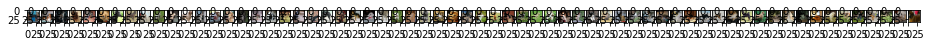

In [6]:
# show train batch
for data in train_ds:
    train_imgs, train_labels = data
    break
print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [7]:
class BasicBlock(Model):
    def __init__(self, filters, kernel_size, padding='valid'):
        super(BasicBlock, self).__init__(name='')

        flt1, flt2 = filters

        self.conv1 = Conv2D(
            flt1,
            1,
            padding=padding,
            kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.dwcovn1 = SeparableConv2D(flt2, kernel_size, padding='same')

        self.conv2 = Conv2D(
            flt1,
            1,
            padding=padding,
            kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

    def call(self, x):
        inp = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu6(x)
        #         print(x)

        x = self.dwcovn1(x)
        x = self.bn2(x)
        x = tf.nn.relu6(x)
        #         print(x)

        x = self.conv2(x)
        x = self.bn3(x)

        x += inp

        return x

In [8]:
img_shape = (64, 32, 32, 3)
blk = BasicBlock((3, 128), 3)
blk.build(img_shape)
print(blk.summary())

Model: "basic_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  12        
_________________________________________________________________
separable_conv2d (SeparableC multiple                  539       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  387       
_________________________________________________________________
batch_normalization (BatchNo multiple                  12        
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
batch_normalization_2 (Batch multiple                  12        
Total params: 1,474
Trainable params: 1,206
Non-trainable params: 268
___________________________________________________

In [9]:
class BokuNet(Model):
    def __init__(self):
        super(BokuNet, self).__init__(name='BokuNet')
        self.conv1 = Conv2D(32, 3, strides=2)
        self.block1 = BasicBlock((32, 64), 3)
        self.conv2 = Conv2D(64, 3)
        self.block2 = BasicBlock((64, 128), 3)

        self.max_pool = MaxPooling2D()

        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(256, activation='relu')
        self.out_fc = Dense(120, activation='softmax')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()


#         self.drop = Dropout(0)

    def call(self, x):
        x = x / 255  # normalization

        y = self.conv1(x)
        y = tf.nn.relu(y)
        y = self.bn1(y)

        y = self.block1(y)
        y = tf.nn.relu(y)
        y = self.bn2(y)

        y = self.conv2(y)
        y = tf.nn.relu(y)
        y = self.max_pool(y)

        y = self.block2(y)
        y = tf.nn.relu(y)

        y = self.flatten(y)
        y = self.fc1(y)
        y = self.fc2(y)

        #         y = self.drop(y)

        y = self.out_fc(y)

        return y

In [10]:
model = BokuNet()
imgs, labels = next(iter(train_ds))
model.build(imgs.shape)
print(model.summary())

Model: "BokuNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  896       
_________________________________________________________________
basic_block_1 (BasicBlock)   multiple                  6048      
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  18496     
_________________________________________________________________
basic_block_2 (BasicBlock)   multiple                  22336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1180

In [13]:
EPOCHS = 1

checkpoint_path = "checkpoint/cp.ckpt"

if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

254/254 [==============================] - ETA: 0s - loss: 4.6944 - accuracy: 0.0363
Epoch 00001: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 47s 185ms/step - loss: 4.6944 - accuracy: 0.0363 - val_loss: 4.6762 - val_accuracy: 0.0321


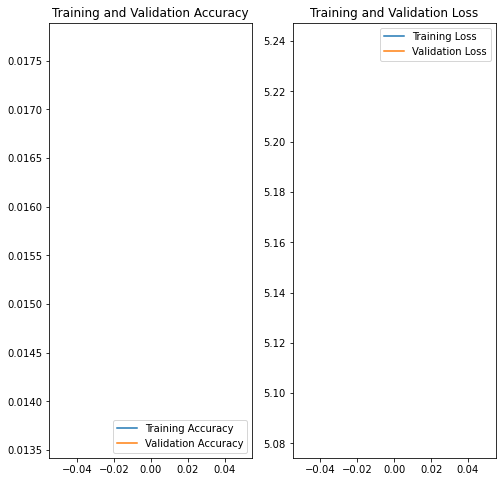

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()